In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
from plot_functions import *
from sklearn.model_selection import KFold

In [2]:
from create_matrix import *

from tensor_custom_core import *
from create_matrix import *
from tensor_custom_core import *
from degree_days import dds
appliance_index = {appliance: APPLIANCES_ORDER.index(appliance) for appliance in APPLIANCES_ORDER}

APPLIANCES = ['fridge', 'hvac', 'wm', 'mw', 'oven', 'dw']
region = "SanDiego"
year = 2014

import os


def un_normalize(x, maximum, minimum):
    return (maximum - minimum) * x + minimum

In [3]:
n_splits = 10
import sys
case=2
a=2
cost='abs'

In [4]:
def get_tensor(df, dfc):
    start, stop = 1, 13
    energy_cols = np.array(
        [['%s_%d' % (appliance, month) for month in range(start, stop)] for appliance in APPLIANCES_ORDER]).flatten()

    static_cols = ['area', 'total_occupants', 'num_rooms']
    static_df = df[static_cols]
    static_df = static_df.div(static_df.max())
    weather_values = np.array(dds[2014][region][start - 1:stop - 1]).reshape(-1, 1)

    dfc = df.copy()

    df = dfc[energy_cols]
    col_max = df.max().max()
    col_min = df.min().min()
    # df = (1.0 * (df - col_min)) / (col_max - col_min)
    tensor = df.values.reshape((len(df), 7, stop - start))
    M, N, O = tensor.shape
    return tensor

In [33]:
au_df, au_dfc = create_matrix_single_region("Austin", year)
au_tensor = get_tensor(au_df, au_dfc)
static_au = au_df[['area','total_occupants','num_rooms']].copy()
static_au['area'] = static_au['area'].div(4000)
static_au['total_occupants'] = static_au['total_occupants'].div(8)
static_au['num_rooms'] = static_au['num_rooms'].div(8)
static_au = static_au.values


In [34]:
df, dfc = create_matrix_single_region("SanDiego", year)
tensor = get_tensor(df, dfc)
static_sd = df[['area','total_occupants','num_rooms']].copy()
static_sd['area'] = static_sd['area'].div(4000)
static_sd['total_occupants'] = static_sd['total_occupants'].div(8)
static_sd['num_rooms'] = static_sd['num_rooms'].div(8)
static_sd = static_sd.values


In [35]:
from sklearn.model_selection import train_test_split, KFold

In [36]:
n_splits = 10


In [37]:
from common import compute_rmse

In [38]:
np.arange(0.1, 1.0, 0.1)

array([ 0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9])

In [39]:
pred = {}
sd = {}
out = {}
n_splits = 10
NUM_RANDOM = 3
n_iter=1200
TRAIN_SPLITS = range(10, 110, 40)
case = 2
num_home=5

cost = 'l21'
algo = 'adagrad'
for static_fac in ['static',None]:
    if static_fac is None:
        H_known_Sd = None
    else:
        H_known_Sd = static_sd    
    np.random.seed(0)
    pred[static_fac] = {}
    for lam in [1e-3, 1e-2, 1e-1, 0, 1]:
        pred[static_fac][lam] = {}
        for a in range(2, 3):

            pred[static_fac][lam][a] = {}
            for random_seed in range(NUM_RANDOM):
                pred[static_fac][lam][a][random_seed] = {}
                for appliance in APPLIANCES_ORDER:
                    pred[static_fac][lam][a][random_seed][appliance] = {f:[] for f in TRAIN_SPLITS}

            kf = KFold(n_splits=n_splits)
            for random_seed in range(NUM_RANDOM):

                for train_percentage in TRAIN_SPLITS:
                    print(lam, static_fac, a, random_seed,train_percentage)
                    for train_max, test in kf.split(df):

                        num_train = int((train_percentage*len(train_max)/100)+0.5)
                        if train_percentage==100:
                            train = train_max
                        else:
                            train, _ = train_test_split(train_max, train_size = train_percentage/100.0, random_state=random_seed)
                        train_ix = df.index[train]
                        test_ix = df.index[test]

                        num_test = len(test_ix)
                        train_test_ix = np.concatenate([test_ix, train_ix])
                        df_t, dfc_t = df.ix[train_test_ix], dfc.ix[train_test_ix]
                        tensor = get_tensor(df_t, dfc_t)
                        tensor_copy = tensor.copy()
                        # First n
                        tensor_copy[:num_test, 1:, :] = np.NaN
                        if static_fac is not None:
                            H, A, T, Hs, As, Ts, HATs, costs = learn_HAT_adagrad(case, tensor_copy, num_home, a, num_iter=n_iter, lr=1, dis=False, cost_function=cost, H_known=H_known_Sd[np.concatenate([test, train])], penalty_coeff=lam)
                        else:
                            H, A, T, Hs, As, Ts, HATs, costs = learn_HAT_adagrad(case, tensor_copy, num_home, a, num_iter=n_iter, lr=1, dis=False, cost_function=cost, penalty_coeff=lam)

                        HAT = multiply_case(H, A, T, case)
                        for appliance in APPLIANCES_ORDER:
                            pred[static_fac][lam][a][random_seed][appliance][train_percentage].append(pd.DataFrame(HAT[:num_test, appliance_index[appliance], :], index=test_ix))


(0.001, 'static', 2, 0, 10)


/Users/nipunbatra/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:47: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix


(0.001, 'static', 2, 0, 50)
(0.001, 'static', 2, 0, 90)
(0.001, 'static', 2, 1, 10)
(0.001, 'static', 2, 1, 50)
(0.001, 'static', 2, 1, 90)
(0.001, 'static', 2, 2, 10)
(0.001, 'static', 2, 2, 50)
(0.001, 'static', 2, 2, 90)
(0.01, 'static', 2, 0, 10)
(0.01, 'static', 2, 0, 50)
(0.01, 'static', 2, 0, 90)
(0.01, 'static', 2, 1, 10)
(0.01, 'static', 2, 1, 50)
(0.01, 'static', 2, 1, 90)
(0.01, 'static', 2, 2, 10)
(0.01, 'static', 2, 2, 50)
(0.01, 'static', 2, 2, 90)
(0.1, 'static', 2, 0, 10)
(0.1, 'static', 2, 0, 50)
(0.1, 'static', 2, 0, 90)
(0.1, 'static', 2, 1, 10)
(0.1, 'static', 2, 1, 50)
(0.1, 'static', 2, 1, 90)
(0.1, 'static', 2, 2, 10)
(0.1, 'static', 2, 2, 50)
(0.1, 'static', 2, 2, 90)
(0, 'static', 2, 0, 10)
(0, 'static', 2, 0, 50)
(0, 'static', 2, 0, 90)
(0, 'static', 2, 1, 10)
(0, 'static', 2, 1, 50)
(0, 'static', 2, 1, 90)
(0, 'static', 2, 2, 10)
(0, 'static', 2, 2, 50)
(0, 'static', 2, 2, 90)
(1, 'static', 2, 0, 10)
(1, 'static', 2, 0, 50)
(1, 'static', 2, 0, 90)
(1, 'static

In [40]:
from common import compute_rmse_fraction

In [41]:
out = {}
algo = 'adagrad'
for static_fac in ['static',None]:
    out[static_fac] = {}
    for lam in [1e-3, 1e-2, 1e-1, 0, 1]:
        out[static_fac][lam] = {}
        for a in range(2, 3):
            out[static_fac][lam][a] = {}
            for random_seed in range(NUM_RANDOM):
                out[static_fac][lam][a][random_seed] = {}

                for appliance in APPLIANCES_ORDER[1:]:
                    out[static_fac][lam][a][random_seed][appliance] = {}
                    for f in TRAIN_SPLITS:
                        s = pd.concat(pred[static_fac][lam][a][random_seed][appliance][f]).ix[df.index]
                        if appliance=="hvac":
                            out[static_fac][lam][a][random_seed][appliance][f] = compute_rmse_fraction(appliance,s[range(4, 10)],'SanDiego')[2]
                        else:   
                            out[static_fac][lam][a][random_seed][appliance][f] = compute_rmse_fraction(appliance, s,'SanDiego')[2]

    

/Users/nipunbatra/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:15: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  from ipykernel import kernelapp as app


In [42]:
import pickle
pickle.dump(out, open('predictions/normal-sparse-static-normalised.pkl','w'))

5.66048651687
6.06131971708
6.28308213805
6.58586505733
5.6711170383


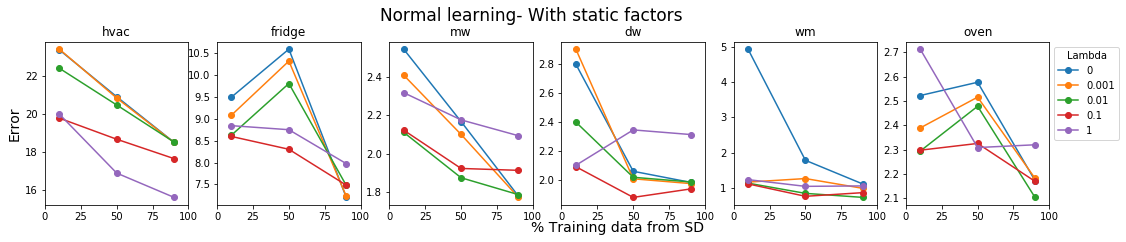

In [43]:
static_res = {}
fig, ax = plt.subplots(ncols=6, figsize=(18, 3))

for lam in [0, 1e-3, 1e-2, 1e-1, 1]:
    static_res[lam] = pd.Panel(out['static'][lam][2]).mean(axis=0)
    for i, appliance in enumerate(APPLIANCES_ORDER[1:]):
        static_res[lam][appliance].plot(ax=ax[i], marker='o', title=appliance)
        ax[i].set_xlim((0, 100))
plt.legend([0, 1e-3, 1e-2, 1e-1, 1], bbox_to_anchor=(1, 1), title='Lambda')
fig.text(0.5, 0, "% Training data from SD", fontsize=14)
ax[0].set_ylabel("Error", fontsize=14)

print static_res[0.1].mean().mean()
print static_res[0.01].mean().mean()
print static_res[0.001].mean().mean()
print static_res[0.0].mean().mean()
print static_res[1].mean().mean()
plt.suptitle("Normal learning- With static factors", fontsize=17,y=1.04)


5.29569115205
5.29331341176
5.40300182878
5.69381795578
5.50673501027


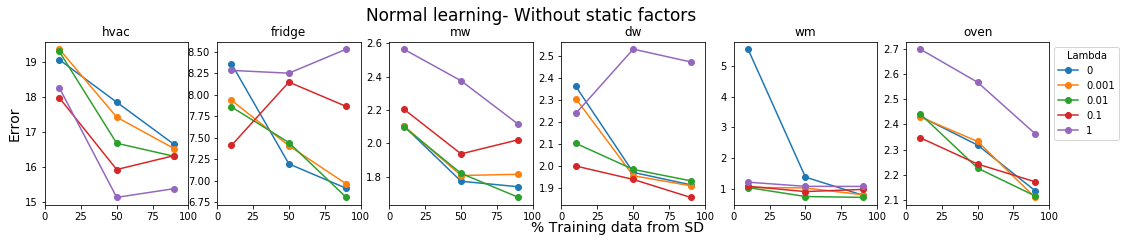

In [44]:
static_res = {}
fig, ax = plt.subplots(ncols=6, figsize=(18, 3))

for lam in [0, 1e-3, 1e-2, 1e-1, 1]:
    static_res[lam] = pd.Panel(out[None][lam][2]).mean(axis=0)
    for i, appliance in enumerate(APPLIANCES_ORDER[1:]):
        static_res[lam][appliance].plot(ax=ax[i], marker='o', title=appliance)
        ax[i].set_xlim((0, 100))
plt.legend([0, 1e-3, 1e-2, 1e-1, 1], bbox_to_anchor=(1, 1), title='Lambda')
fig.text(0.5, 0, "% Training data from SD", fontsize=14)
ax[0].set_ylabel("Error", fontsize=14)
plt.suptitle("Normal learning- Without static factors", fontsize=17,y=1.04)

print static_res[0.1].mean().mean()
print static_res[0.01].mean().mean()
print static_res[0.001].mean().mean()
print static_res[0.0].mean().mean()
print static_res[1].mean().mean()
